In [1]:
import json
import pandas as pd
pd.set_option('display.max_colwidth', 150)

In [2]:
df_opener_en_train = pd.read_json("data/opener_en/train.json")
df_opener_es_train = pd.read_json("data/opener_es/train.json")
df_opener_en_dev = pd.read_json("data/opener_en/dev.json")
df_opener_es_dev = pd.read_json("data/opener_es/dev.json")

In [3]:
print(df_opener_en_train['sent_id'].nunique() , df_opener_en_train.shape[0])
print(df_opener_es_train['sent_id'].nunique(), df_opener_es_train.shape[0])
print(df_opener_en_dev['sent_id'].nunique(), df_opener_en_dev.shape[0])
print(df_opener_es_dev['sent_id'].nunique(), df_opener_es_dev.shape[0])

1744 1744
1438 1438
249 249
206 206


# Percent Null (Opinions are misssing outright in Train/Dev)

In [4]:
pct_null_en_train = df_opener_en_train['opinions'].apply(lambda x: 1 if len(x) == 0 else 0).sum() / len(df_opener_en_train)
pct_null_es_train = df_opener_es_train['opinions'].apply(lambda x: 1 if len(x) == 0 else 0).sum() / len(df_opener_es_train)
pct_null_en_dev = df_opener_en_dev['opinions'].apply(lambda x: 1 if len(x) == 0 else 0).sum() / len(df_opener_en_dev)
pct_null_es_dev = df_opener_es_dev['opinions'].apply(lambda x: 1 if len(x) == 0 else 0).sum() / len(df_opener_es_dev)

In [5]:
print(pct_null_en_train) 
print(pct_null_es_train) 
print(pct_null_en_dev) 
print(pct_null_es_dev) 

0.19724770642201836
0.12934631432545202
0.20481927710843373
0.1553398058252427


In [6]:
df_opener_en_train

,sent_id,text,opinions
0,opener_en/kaf/hotel/english00192_e3fe22eeb360723a699504a27e13065e-1,Experienced staff and had a memorable stay,[]
1,opener_en/kaf/hotel/english00192_e3fe22eeb360723a699504a27e13065e-2,India as a country has always fascinated me and all of my friends who have been there always have wonderful things to say about it .,[]
2,opener_en/kaf/hotel/english00192_e3fe22eeb360723a699504a27e13065e-3,One of my friends who had been there before was planning a weeklong trip to Rajasthan in India and I decided to join him this time .,[]
3,opener_en/kaf/hotel/english00192_e3fe22eeb360723a699504a27e13065e-4,"Yes , it really was a great experience and we visited various places but the most wonderful part of the trip was our stay at the Oberoi Udaivilas ...","[{'Source': [[], []], 'Target': [['the Oberoi Udaivilas Luxury Hotel'], ['125:158']], 'Polar_expression': [['the most wonderful part of the trip']..."
4,opener_en/kaf/hotel/english00192_e3fe22eeb360723a699504a27e13065e-5,I can ’t explain in words how grand this place looks .,"[{'Source': [[], []], 'Target': [['this place'], ['36:46']], 'Polar_expression': [['how grand', 'looks'], ['26:35', '47:52']], 'Polarity': 'Positi..."
...,...,...,...
1739,opener_en/kaf/hotel/english00011_0b57ac0ca85693440968f8de6deb7ca4-4,"Hotel offers nice spa , large pool area and enough space on its beach where I enjoyed relaxing after the game .","[{'Source': [[], []], 'Target': [['Hotel'], ['0:5']], 'Polar_expression': [['offers'], ['6:12']], 'Polarity': 'Positive', 'Intensity': 'Standard'}..."
1740,opener_en/kaf/hotel/english00011_0b57ac0ca85693440968f8de6deb7ca4-5,Hospitality and services at the highest level .,"[{'Source': [[], []], 'Target': [['Hospitality'], ['0:11']], 'Polar_expression': [['at the highest level'], ['25:45']], 'Polarity': 'Positive', 'I..."
1741,opener_en/kaf/hotel/english00011_0b57ac0ca85693440968f8de6deb7ca4-6,I will definitely come back !,"[{'Source': [['I'], ['0:1']], 'Target': [[], []], 'Polar_expression': [['will definitely come back !'], ['2:29']], 'Polarity': 'Positive', 'Intens..."
1742,opener_en/kaf/hotel/english00011_0b57ac0ca85693440968f8de6deb7ca4-7,;,[]


In [7]:
def normalize_jsons(filepath):

    with open(filepath, 'r') as json_file:
        json_data = json.load(json_file)
        df = pd.json_normalize(
            json_data,
            record_path=["opinions"],
            sep="_",
            meta=[
                ['sent_id'],
                ['text']
            ],
            errors='ignore'
        )

    df[['Source_string','Source_index']] = pd.DataFrame(df['Source'].tolist(), index = df.index)
    df[['Target_string','Target_index']] = pd.DataFrame(df['Target'].tolist(), index = df.index)
    df[['Polar_expression_string','Polar_expression_index']] = pd.DataFrame(df['Polar_expression'].tolist(), index = df.index)
    df['Implicit_holder'] = df['Source_string'].apply(lambda x: 1 if len(x) == 0 else 0)
    df['Implicit_target'] = df['Target_string'].apply(lambda x: 1 if len(x) == 0 else 0)
    df['Implicit_holder_target'] = (df['Implicit_holder'] == 1) & (df['Implicit_target'] == 1)
    df['Implicit_expression'] = df['Polar_expression_string'].apply(lambda x: 1 if len(x) == 0 else 0)
    df['Implicit_target_exclusive'] = (df['Implicit_target']==1) & (df['Implicit_holder'] == 0) & (df['Implicit_expression']==0 ) 
    df['Implicit_holder_exclusive'] = (df['Implicit_target']==0) & (df['Implicit_holder'] == 1) & (df['Implicit_expression']==0 )
    
    df['H-A-O'] = df.apply(lambda row: 1 if (row['Implicit_target'] == 0 and row['Implicit_holder'] ==0) and row['Implicit_expression'] ==0 else 0, axis=1)
    
#    df['H-A-O'] =  (df['Implicit_target']==0) & (df['Implicit_holder'] == 0) & (df['Implicit_expression']==0 )
    df['H-IA-IO'] =(df['Implicit_target']==1) & (df['Implicit_holder'] == 0) & (df['Implicit_expression']==1 )
    df['H-A-IO'] = (df['Implicit_target']==0) & (df['Implicit_holder'] == 0) & (df['Implicit_expression']==1 )
    df['H-IA-O']=  (df['Implicit_target']==1) & (df['Implicit_holder'] == 0) & (df['Implicit_expression']==0 )
    df['IH-A-O']=  (df['Implicit_target']==0) & (df['Implicit_holder'] == 1) & (df['Implicit_expression']==0 )
    df['IH-A-IO']= (df['Implicit_target']==0) & (df['Implicit_holder'] == 1) & (df['Implicit_expression']==1 )
    df['IH-IA-O']= (df['Implicit_target']==1) & (df['Implicit_holder'] == 1) & (df['Implicit_expression']==0 )
    df['IH-IA-IO']= (df['Implicit_target']==1) & (df['Implicit_holder'] == 1) & (df['Implicit_expression']==1 )


    df = df.reindex(
        columns= [
        'text',
        'sent_id',
        'Source',
        'Source_string',
        'Source_index',
        'Target',
        'Target_string',
        'Target_index',
        'Polar_expression',
        'Polar_expression_string',
        'Polar_expression_index',
        'Polarity',
        'Intensity',
        'Implicit_holder',
        'Implicit_target',
        'Implicit_holder_target',
        'Implicit_expression',
        'Implicit_target_exclusive',
        'Implicit_holder_exclusive',
        'H-A-O', 'H-IA-IO','H-A-IO','H-IA-O','IH-A-O', 'IH-A-IO', 'IH-IA-O', 'IH-IA-IO'
        ]
    )

    return df

In [8]:
df_en_train = normalize_jsons("data/opener_en/train.json")
df_es_train = normalize_jsons("data/opener_es/train.json")
df_en_dev = normalize_jsons("data/opener_en/dev.json")
df_es_dev = normalize_jsons("data/opener_es/dev.json")


In [9]:
df_en_train.columns

# df_en.dtypes
# df_en.columns
# df_en.shape

Index(['text', 'sent_id', 'Source', 'Source_string', 'Source_index', 'Target',
       'Target_string', 'Target_index', 'Polar_expression',
       'Polar_expression_string', 'Polar_expression_index', 'Polarity',
       'Intensity', 'Implicit_holder', 'Implicit_target',
       'Implicit_holder_target', 'Implicit_expression',
       'Implicit_target_exclusive', 'Implicit_holder_exclusive', 'H-A-O',
       'H-IA-IO', 'H-A-IO', 'H-IA-O', 'IH-A-O', 'IH-A-IO', 'IH-IA-O',
       'IH-IA-IO'],
      dtype='object')

In [10]:
df_en_train

,text,sent_id,Source,Source_string,Source_index,Target,Target_string,Target_index,Polar_expression,Polar_expression_string,...,Implicit_target_exclusive,Implicit_holder_exclusive,H-A-O,H-IA-IO,H-A-IO,H-IA-O,IH-A-O,IH-A-IO,IH-IA-O,IH-IA-IO
0,"Yes , it really was a great experience and we visited various places but the most wonderful part of the trip was our stay at the Oberoi Udaivilas ...",opener_en/kaf/hotel/english00192_e3fe22eeb360723a699504a27e13065e-4,"[[], []]",[],[],"[[the Oberoi Udaivilas Luxury Hotel], [125:158]]",[the Oberoi Udaivilas Luxury Hotel],[125:158],"[[the most wonderful part of the trip], [73:108]]",[the most wonderful part of the trip],...,False,True,0,False,False,False,True,False,False,False
1,I can ’t explain in words how grand this place looks .,opener_en/kaf/hotel/english00192_e3fe22eeb360723a699504a27e13065e-5,"[[], []]",[],[],"[[this place], [36:46]]",[this place],[36:46],"[[how grand, looks], [26:35, 47:52]]","[how grand, looks]",...,False,True,0,False,False,False,True,False,False,False
2,It is a unique blend of the old world royal charm and the modern luxuries .,opener_en/kaf/hotel/english00192_e3fe22eeb360723a699504a27e13065e-6,"[[], []]",[],[],"[[It], [0:2]]",[It],[0:2],"[[unique blend of the old world royal charm and the modern luxuries], [8:73]]",[unique blend of the old world royal charm and the modern luxuries],...,False,True,0,False,False,False,True,False,False,False
3,I ’m definitely going there again whenever I get a chance .,opener_en/kaf/hotel/english00192_e3fe22eeb360723a699504a27e13065e-7,"[[I], [0:1]]",[I],[0:1],"[[there], [22:27]]",[there],[22:27],"[[definitely going, again], [5:21, 28:33]]","[definitely going, again]",...,False,False,1,False,False,False,False,False,False,False
4,Bit pricey and but away from center,opener_en/kaf/hotel/english00073_4ec3ca101056f97554290430ff17c373-1,"[[], []]",[],[],"[[], []]",[],[],"[[Bit pricey], [0:10]]",[Bit pricey],...,False,False,0,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2879,"Hotel offers nice spa , large pool area and enough space on its beach where I enjoyed relaxing after the game .",opener_en/kaf/hotel/english00011_0b57ac0ca85693440968f8de6deb7ca4-4,"[[], []]",[],[],"[[its beach], [60:69]]",[its beach],[60:69],"[[enough space], [44:56]]",[enough space],...,False,True,0,False,False,False,True,False,False,False
2880,Hospitality and services at the highest level .,opener_en/kaf/hotel/english00011_0b57ac0ca85693440968f8de6deb7ca4-5,"[[], []]",[],[],"[[Hospitality], [0:11]]",[Hospitality],[0:11],"[[at the highest level], [25:45]]",[at the highest level],...,False,True,0,False,False,False,True,False,False,False
2881,Hospitality and services at the highest level .,opener_en/kaf/hotel/english00011_0b57ac0ca85693440968f8de6deb7ca4-5,"[[], []]",[],[],"[[services], [16:24]]",[services],[16:24],"[[at the highest level], [25:45]]",[at the highest level],...,False,True,0,False,False,False,True,False,False,False
2882,I will definitely come back !,opener_en/kaf/hotel/english00011_0b57ac0ca85693440968f8de6deb7ca4-6,"[[I], [0:1]]",[I],[0:1],"[[], []]",[],[],"[[will definitely come back !], [2:29]]",[will definitely come back !],...,True,False,0,False,False,True,False,False,False,False


In [11]:
df_es_train.head(3)

,text,sent_id,Source,Source_string,Source_index,Target,Target_string,Target_index,Polar_expression,Polar_expression_string,...,Implicit_target_exclusive,Implicit_holder_exclusive,H-A-O,H-IA-IO,H-A-IO,H-IA-O,IH-A-O,IH-A-IO,IH-IA-O,IH-IA-IO
0,Encanto real,opener_es/kaf/hotel/spanish00126_b31868b432e4a60a655a47dbb2fbe7ec-1,"[[], []]",[],[],"[[], []]",[],[],"[[Encanto real], [0:12]]",[Encanto real],...,False,False,0,False,False,False,False,False,True,False
1,volveria si tuviera la ocasion me he sentido como una princesa en un cuento maravillosooooo.las vistas magicas el personal superior en calidad y l...,opener_es/kaf/hotel/spanish00126_b31868b432e4a60a655a47dbb2fbe7ec-2,"[[], []]",[],[],"[[vistas], [96:102]]",[vistas],[96:102],"[[magicas], [103:110]]",[magicas],...,False,True,0,False,False,False,True,False,False,False
2,volveria si tuviera la ocasion me he sentido como una princesa en un cuento maravillosooooo.las vistas magicas el personal superior en calidad y l...,opener_es/kaf/hotel/spanish00126_b31868b432e4a60a655a47dbb2fbe7ec-2,"[[], []]",[],[],"[[la comida], [145:154]]",[la comida],[145:154],"[[sin palabras], [155:167]]",[sin palabras],...,False,True,0,False,False,False,True,False,False,False


In [12]:
df_en_train['IH-IA-IO'].sum()

0

# Token Distribution

In [13]:
fpath = !pwd

from transformers import AutoTokenizer

plm_model_name = 'roberta-large'
plm_model_path= f'{fpath[0]}/pretrained_models/roberta-large'
tokenizer = AutoTokenizer.from_pretrained(plm_model_path)

length = len(tokenizer.encode('text'))
length

3

In [14]:
# Create a new column with the number of words from the 'text' column
df_en_train['Token Count'] = df_en_train['text'].apply(lambda x: len(tokenizer.encode(x)))
df_es_train['Token Count'] = df_es_train['text'].apply(lambda x: len(tokenizer.encode(x)))
df_en_dev['Token Count'] = df_en_dev['text'].apply(lambda x: len(tokenizer.encode(x)))
df_es_dev['Token Count'] = df_es_dev['text'].apply(lambda x: len(tokenizer.encode(x)))


In [15]:
df_en_train_dev = pd.concat([df_en_train, df_en_dev])
df_es_train_dev = pd.concat([df_es_train, df_es_dev])


assert df_en_train.shape[0] + df_en_dev.shape[0] == df_en_train_dev.shape[0]
assert df_es_train.shape[0] + df_es_dev.shape[0] == df_es_train_dev.shape[0]

print(f' The # of records for combined train and dev sets are {df_en_train_dev.shape[0]} , {df_es_train_dev.shape[0]}')

 The # of records for combined train and dev sets are 3284 , 3429


In [16]:
# ! pip install seaborn

In [17]:
df_en_train_dev.head()

,text,sent_id,Source,Source_string,Source_index,Target,Target_string,Target_index,Polar_expression,Polar_expression_string,...,Implicit_holder_exclusive,H-A-O,H-IA-IO,H-A-IO,H-IA-O,IH-A-O,IH-A-IO,IH-IA-O,IH-IA-IO,Token Count
0,"Yes , it really was a great experience and we visited various places but the most wonderful part of the trip was our stay at the Oberoi Udaivilas ...",opener_en/kaf/hotel/english00192_e3fe22eeb360723a699504a27e13065e-4,"[[], []]",[],[],"[[the Oberoi Udaivilas Luxury Hotel], [125:158]]",[the Oberoi Udaivilas Luxury Hotel],[125:158],"[[the most wonderful part of the trip], [73:108]]",[the most wonderful part of the trip],...,True,0,False,False,False,True,False,False,False,38
1,I can ’t explain in words how grand this place looks .,opener_en/kaf/hotel/english00192_e3fe22eeb360723a699504a27e13065e-5,"[[], []]",[],[],"[[this place], [36:46]]",[this place],[36:46],"[[how grand, looks], [26:35, 47:52]]","[how grand, looks]",...,True,0,False,False,False,True,False,False,False,16
2,It is a unique blend of the old world royal charm and the modern luxuries .,opener_en/kaf/hotel/english00192_e3fe22eeb360723a699504a27e13065e-6,"[[], []]",[],[],"[[It], [0:2]]",[It],[0:2],"[[unique blend of the old world royal charm and the modern luxuries], [8:73]]",[unique blend of the old world royal charm and the modern luxuries],...,True,0,False,False,False,True,False,False,False,19
3,I ’m definitely going there again whenever I get a chance .,opener_en/kaf/hotel/english00192_e3fe22eeb360723a699504a27e13065e-7,"[[I], [0:1]]",[I],[0:1],"[[there], [22:27]]",[there],[22:27],"[[definitely going, again], [5:21, 28:33]]","[definitely going, again]",...,False,1,False,False,False,False,False,False,False,16
4,Bit pricey and but away from center,opener_en/kaf/hotel/english00073_4ec3ca101056f97554290430ff17c373-1,"[[], []]",[],[],"[[], []]",[],[],"[[Bit pricey], [0:10]]",[Bit pricey],...,False,0,False,False,False,False,False,True,False,9


In [18]:
df_es_train_dev.head()

,text,sent_id,Source,Source_string,Source_index,Target,Target_string,Target_index,Polar_expression,Polar_expression_string,...,Implicit_holder_exclusive,H-A-O,H-IA-IO,H-A-IO,H-IA-O,IH-A-O,IH-A-IO,IH-IA-O,IH-IA-IO,Token Count
0,Encanto real,opener_es/kaf/hotel/spanish00126_b31868b432e4a60a655a47dbb2fbe7ec-1,"[[], []]",[],[],"[[], []]",[],[],"[[Encanto real], [0:12]]",[Encanto real],...,False,0,False,False,False,False,False,True,False,5
1,volveria si tuviera la ocasion me he sentido como una princesa en un cuento maravillosooooo.las vistas magicas el personal superior en calidad y l...,opener_es/kaf/hotel/spanish00126_b31868b432e4a60a655a47dbb2fbe7ec-2,"[[], []]",[],[],"[[vistas], [96:102]]",[vistas],[96:102],"[[magicas], [103:110]]",[magicas],...,True,0,False,False,False,True,False,False,False,73
2,volveria si tuviera la ocasion me he sentido como una princesa en un cuento maravillosooooo.las vistas magicas el personal superior en calidad y l...,opener_es/kaf/hotel/spanish00126_b31868b432e4a60a655a47dbb2fbe7ec-2,"[[], []]",[],[],"[[la comida], [145:154]]",[la comida],[145:154],"[[sin palabras], [155:167]]",[sin palabras],...,True,0,False,False,False,True,False,False,False,73
3,volveria si tuviera la ocasion me he sentido como una princesa en un cuento maravillosooooo.las vistas magicas el personal superior en calidad y l...,opener_es/kaf/hotel/spanish00126_b31868b432e4a60a655a47dbb2fbe7ec-2,"[[], []]",[],[],"[[el personal], [111:122]]",[el personal],[111:122],"[[superior en calidad], [123:142]]",[superior en calidad],...,True,0,False,False,False,True,False,False,False,73
4,volveria si tuviera la ocasion me he sentido como una princesa en un cuento maravillosooooo.las vistas magicas el personal superior en calidad y l...,opener_es/kaf/hotel/spanish00126_b31868b432e4a60a655a47dbb2fbe7ec-2,"[[me], [31:33]]",[me],[31:33],"[[], []]",[],[],"[[he sentido como una princesa en un cuento maravillosooooo.las], [34:95]]",[he sentido como una princesa en un cuento maravillosooooo.las],...,False,0,False,False,True,False,False,False,False,73


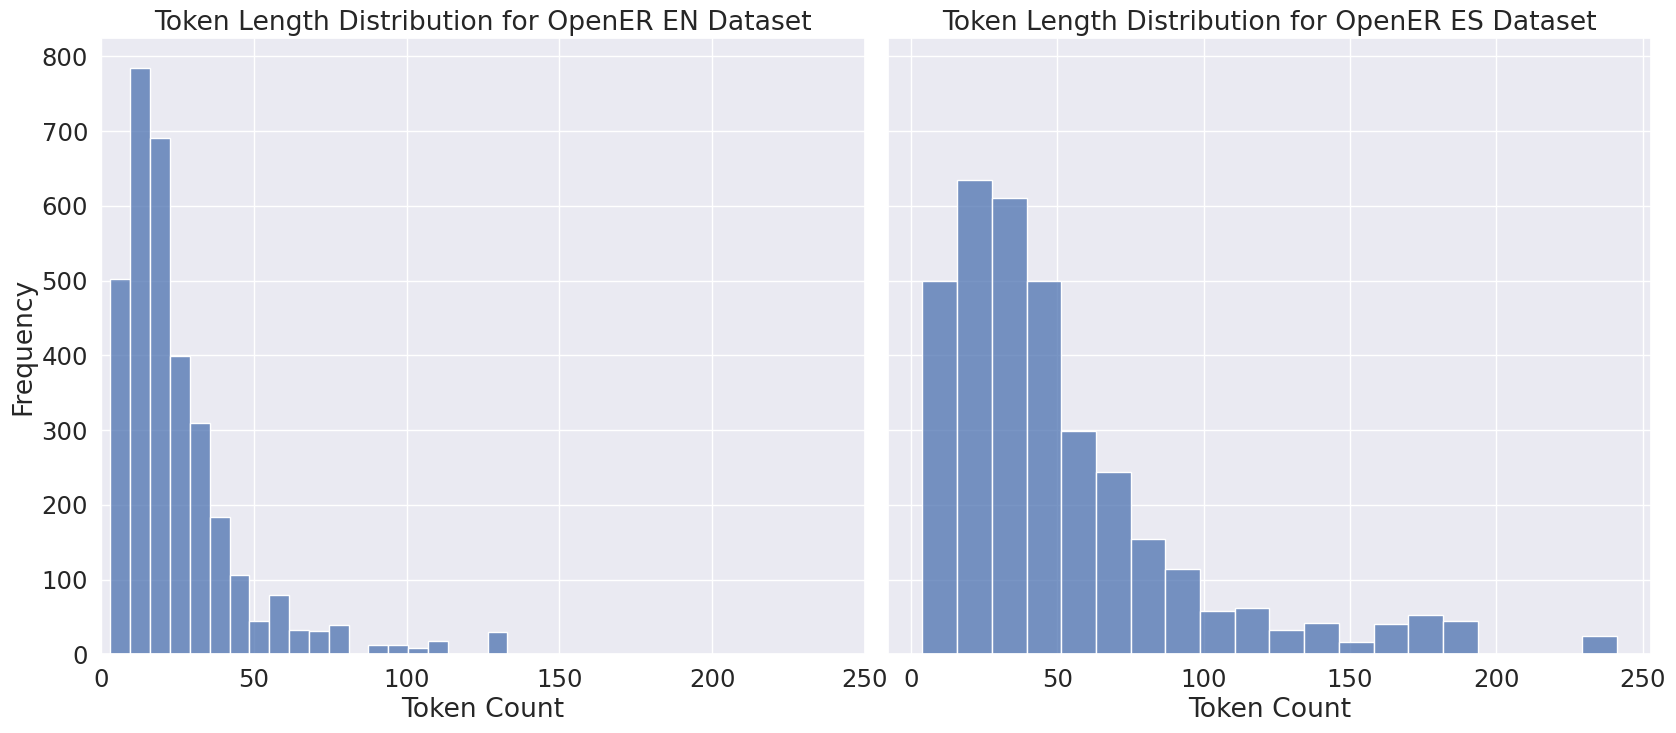

In [90]:
# ! pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8),  sharey=True)
ax1.set_xlim(left=0, right=250)
ax1.set_xlim(left=0, right=250)

fig.subplots_adjust(hspace=0.5, wspace=0.03)
sns.set(font_scale=1.6)

with sns.axes_style("dark"):

    sns.histplot(df_en_train_dev['Token Count'], ax=ax1, bins = 20).set(xlabel = "Token Count", ylabel = "Frequency",
        title="Token Length Distribution for OpenER EN Dataset")
    sns.histplot(df_es_train_dev['Token Count'],ax=ax2, bins = 20).set(xlabel = "Token Count", ylabel = "Frequency",
        title="Token Length Distribution for OpenER ES Dataset")

plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# # Plot the distribution of the 'word_count' column using matplotlib
# plt.subplot(1, 2, 1)
# plt.hist(df_en_train_dev['word_count'], bins=10, edgecolor='black', rwidth=2)
# plt.title("Token Length Distribution for OpenER EN Dataset")
# plt.xlabel("Number of tokens")
# plt.ylabel("Frequency")

# plt.subplot(1, 2, 2)
# plt.hist(df_es_train_dev['word_count'], bins=10, edgecolor='black', rwidth=2)
# plt.title("Token Length Distribution for OpenER ES Dataset")
# plt.xlabel("Number of tokens")
# plt.ylabel("Frequency")
# plt.tight_layout()
# plt.show()


In [20]:
df_en_train[df_en_train['word_count'] < 16]

KeyError: 'word_count'

## Implicit Percentages

In [21]:
def json_eda(df):
# some basic counts and percentages
    
    sentances = df['sent_id'].nunique()
    holders = len(df[df['Source_string'].apply(len) > 0])
    targets = len(df[df['Target_string'].apply(len) > 0])
    polarity = len(df[df['Polarity'].apply(len) > 0])
    expression = len(df[df['Polar_expression_string'].apply(len) > 0])

    print(f'n sentances: {sentances} \nn holders: {holders} \nn targets: {targets} \nn polarity: {polarity} \nn expression: {expression}')

    perIH = df['Implicit_holder'].sum()/len(df)
    perIT = df['Implicit_target'].sum()/len(df)
    perIE = df['Implicit_expression'].sum()/len(df)
    perIHIT = df['Implicit_holder_target'].sum()/len(df)
    exclIT = df['Implicit_target_exclusive'].sum()/len(df)
    exclIH = df['Implicit_holder_exclusive'].sum()/len(df)

    print(f'\nImplicit percentages in the dataset: \npercent implicit holder: {perIH},\npercent implicit target: {perIT},\npercent implicit holder implicit target: {perIHIT}, \npercent implicit expression: {perIE}')

    print(f'\nImplicit target exclusive: {exclIT}')
    print(f'\nImplicit holder exclusive: {exclIH}')

    HAO=df['H-A-O'].sum()/len(df)
    HIAIO=df['H-IA-IO'].sum()/len(df)
    HAIO=df['H-A-IO'].sum()/len(df)
    HIAO=df['H-IA-O'].sum()/len(df)
    IHAO=df['IH-A-O'].sum()/len(df)
    IHAIO=df['IH-A-IO'].sum()/len(df)
    IHIAO=df['IH-IA-O'].sum()/len(df)

    print(f'H-A-O: {HAO}')
    print(f'H-IA-IO: {HIAIO}')
    print(f'H-A-IO: {HAIO}')
    print(f'H-IA-O: {HIAIO}')
    print(f'IH-A-O: {IHAO}')
    print(f'IH-A-IO: {IHAIO}')
    print(f'IH-IA-O: {IHIAO}')
        

    cross_polarity_intensity = pd.crosstab(df['Polarity'], df['Intensity'], margins = True, normalize='all') * 100
    display(cross_polarity_intensity)

    df_count_per_sent = pd.DataFrame(df.groupby(['sent_id'])['Polar_expression'].count())

    count_mult_opinion =  (df_count_per_sent['Polar_expression'] > 1).sum()
    perc_mult_opinion = (df_count_per_sent['Polar_expression'] > 1).sum() / df.shape[0]

    print(f'The total count of sentiments with multiple opinions is: {count_mult_opinion}')
    print(f'The percent of sentiments with multiple opinions is: {perc_mult_opinion}')
    
    

    

In [22]:
json_eda(df_en_train)

n sentances: 1400 
n holders: 266 
n targets: 2679 
n polarity: 2884 
n expression: 2884

Implicit percentages in the dataset: 
percent implicit holder: 0.9077669902912622,
percent implicit target: 0.07108183079056865,
percent implicit holder implicit target: 0.05513176144244106, 
percent implicit expression: 0.0

Implicit target exclusive: 0.0159500693481276

Implicit holder exclusive: 0.852635228848821
H-A-O: 0.07628294036061026
H-IA-IO: 0.0
H-A-IO: 0.0
H-IA-O: 0.0
IH-A-O: 0.852635228848821
IH-A-IO: 0.0
IH-IA-O: 0.05513176144244106


Intensity,Standard,Strong,All
Polarity,,,
Negative,22.919556,4.230236,27.149792
Positive,48.127601,24.722607,72.850208
All,71.047157,28.952843,100.000000


The total count of sentiments with multiple opinions is: 762
The percent of sentiments with multiple opinions is: 0.2642163661581137


In [ ]:
# df_en_train = normalize_jsons("data/opener_en/train.json")
# df_es_train = normalize_jsons("data/opener_es/train.json")
# df_en_dev = normalize_jsons("data/opener_en/dev.json")
# df_es_dev = normalize_jsons("data/opener_es/dev.json")
# df_en_test = normalize_jsons("data/opener_en/test.json")
# df_es_test = normalize_jsons("data/opener_es/test.json")


In [23]:
json_eda(df_es_train)

n sentances: 1252 
n holders: 176 
n targets: 2748 
n polarity: 3042 
n expression: 3042

Implicit percentages in the dataset: 
percent implicit holder: 0.9421433267587114,
percent implicit target: 0.09664694280078895,
percent implicit holder implicit target: 0.08481262327416174, 
percent implicit expression: 0.0

Implicit target exclusive: 0.011834319526627219

Implicit holder exclusive: 0.8573307034845496
H-A-O: 0.04602235371466141
H-IA-IO: 0.0
H-A-IO: 0.0
H-IA-O: 0.0
IH-A-O: 0.8573307034845496
IH-A-IO: 0.0
IH-IA-O: 0.08481262327416174


Intensity,Standard,Strong,All
Polarity,,,
Negative,16.074951,2.662722,18.737673
Positive,51.314924,29.947403,81.262327
All,67.389875,32.610125,100.000000


The total count of sentiments with multiple opinions is: 752
The percent of sentiments with multiple opinions is: 0.24720578566732412


In [26]:
json_eda(df_en_dev)


n sentances: 198 
n holders: 49 
n targets: 371 
n polarity: 400 
n expression: 400

Implicit percentages in the dataset: 
percent implicit holder: 0.8775,
percent implicit target: 0.0725,
percent implicit holder implicit target: 0.0525, 
percent implicit expression: 0.0

Implicit target exclusive: 0.02

Implicit holder exclusive: 0.825
H-A-O: 0.1025
H-IA-IO: 0.0
H-A-IO: 0.0
H-IA-O: 0.0
IH-A-O: 0.825
IH-A-IO: 0.0
IH-IA-O: 0.0525


Intensity,Standard,Strong,All
Polarity,,,
Negative,24.75,4.25,29.0
Positive,42.50,28.50,71.0
All,67.25,32.75,100.0


The total count of sentiments with multiple opinions is: 115
The percent of sentiments with multiple opinions is: 0.2875


In [27]:
json_eda(df_es_dev)

n sentances: 174 
n holders: 23 
n targets: 363 
n polarity: 387 
n expression: 387

Implicit percentages in the dataset: 
percent implicit holder: 0.9405684754521964,
percent implicit target: 0.06201550387596899,
percent implicit holder implicit target: 0.06201550387596899, 
percent implicit expression: 0.0

Implicit target exclusive: 0.0

Implicit holder exclusive: 0.8785529715762274
H-A-O: 0.059431524547803614
H-IA-IO: 0.0
H-A-IO: 0.0
H-IA-O: 0.0
IH-A-O: 0.8785529715762274
IH-A-IO: 0.0
IH-IA-O: 0.06201550387596899


Intensity,Standard,Strong,All
Polarity,,,
Negative,16.020672,2.067183,18.087855
Positive,52.713178,29.198966,81.912145
All,68.733850,31.266150,100.000000


The total count of sentiments with multiple opinions is: 97
The percent of sentiments with multiple opinions is: 0.25064599483204136


In [28]:
display(df_en_train['Polarity'].unique())
display(df_en_train['Intensity'].unique())

cross_polarity_intensity = pd.crosstab(df_en_train['Polarity'], df_en_train['Intensity'], margins = True, normalize='all') * 100
display(cross_polarity_intensity)

# perc_strong_pos = df_en_train[ (df_en_train['Polarity'] == "Positive") & (df_en_train['Intensity'] == "Strong")].shape[0]/ df_en_train.shape[0]
# perc_standard_pos = df_en_train[ (df_en_train['Polarity'] == "Positive") & (df_en_train['Intensity'] == "Standard")].shape[0]/ df_en_train.shape[0]
# perc_strong_neg = df_en_train[ (df_en_train['Polarity'] == "Negative") & (df_en_train['Intensity'] == "Strong")].shape[0]/ df_en_train.shape[0]
# perc_standard_pos = df_en_train[ (df_en_train['Polarity'] == "Negative") & (df_en_train['Intensity'] == "Standard")].shape[0]/ df_en_train.shape[0]

array(['Positive', 'Negative'], dtype=object)

array(['Standard', 'Strong'], dtype=object)

Intensity,Standard,Strong,All
Polarity,,,
Negative,22.919556,4.230236,27.149792
Positive,48.127601,24.722607,72.850208
All,71.047157,28.952843,100.000000


In [29]:
df_count_per_sent = pd.DataFrame(df_en_train.groupby(['sent_id'])['Polar_expression'].count())

In [30]:
print((df_count_per_sent['Polar_expression'] > 1).sum() )
(df_count_per_sent['Polar_expression'] > 1).sum() / df_en_train.shape[0]

762


0.2642163661581137

In [31]:
for row in df_en_train['Polar_expression_string']:
    print(row)

['the most wonderful part of the trip']
['how grand', 'looks']
['unique blend of the old world royal charm and the modern luxuries']
['definitely going', 'again']
['Bit pricey']
['away from center']
['20 · 30 minutes walking', 'to Dubling city center']
['There is no']
['There is no']
['with discovery']
['HBO']
['no']
['ok']
['noises']
['complaining']
['being old']
['quiet']
['with view on wall']
['quite international']
['very good']
['too much for what it offers']
['Relax in the city']
['only']
['Perfect']
['just out of']
['Easy to reach by car']
['there are enough']
['perfect']
['can be crowded on saturday']
['Clean']
['renewed']
['excellent']
['Quite comfortable']
['definitely the best']
['Very close to Flower Market , Pathé cinema , bars']
['Very convenient nearby tram stop']
['delicious']
['great']
['neatly decorated']
['spacious']
["only a few minutes ' walk or 2 tram stops away"]
['highly recommended']
['good']
['Clean']
['sizeable']
['There were']
['larger']
['smaller']
['very b

In [32]:
df_en_train[df_en_train.duplicated("sent_id")]

,text,sent_id,Source,Source_string,Source_index,Target,Target_string,Target_index,Polar_expression,Polar_expression_string,...,Implicit_holder_exclusive,H-A-O,H-IA-IO,H-A-IO,H-IA-O,IH-A-O,IH-A-IO,IH-IA-O,IH-IA-IO,Token Count
5,Bit pricey and but away from center,opener_en/kaf/hotel/english00073_4ec3ca101056f97554290430ff17c373-1,"[[], []]",[],[],"[[], []]",[],[],"[[away from center], [19:35]]",[away from center],...,False,0,False,False,False,False,False,True,False,9
8,There is no sauna nor swimming pool .,opener_en/kaf/hotel/english00073_4ec3ca101056f97554290430ff17c373-3,"[[], []]",[],[],"[[swimming pool], [22:35]]",[swimming pool],[22:35],"[[There is no], [0:11]]",[There is no],...,True,0,False,False,False,True,False,False,False,11
10,Flat TV with discovery but no HBO .,opener_en/kaf/hotel/english00073_4ec3ca101056f97554290430ff17c373-4,"[[], []]",[],[],"[[Flat TV], [0:7]]",[Flat TV],[0:7],"[[HBO], [30:33]]",[HBO],...,True,0,False,False,False,True,False,False,False,11
11,Flat TV with discovery but no HBO .,opener_en/kaf/hotel/english00073_4ec3ca101056f97554290430ff17c373-4,"[[], []]",[],[],"[[Flat TV], [0:7]]",[Flat TV],[0:7],"[[no], [27:29]]",[no],...,True,0,False,False,False,True,False,False,False,11
13,In my room mattress was ok and it was quiet but I had room with view on wall : ) Most of colleagues were complaining for the mattresses being old ...,opener_en/kaf/hotel/english00073_4ec3ca101056f97554290430ff17c373-5,"[[Most of colleagues], [81:99]]",[Most of colleagues],[81:99],"[[the mattresses], [121:135]]",[the mattresses],[121:135],"[[noises], [159:165]]",[noises],...,False,1,False,False,False,False,False,False,False,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,"Golf courses can be easily reached from the hotel , tee times and transport have been organised by the hotel ( Ms. Ö .",opener_en/kaf/hotel/english00011_0b57ac0ca85693440968f8de6deb7ca4-2,"[[], []]",[],[],"[[Golf courses], [0:12]]",[Golf courses],[0:12],"[[can be easily reached], [13:34]]",[can be easily reached],...,True,0,False,False,False,True,False,False,False,28
2877,"Hotel offers nice spa , large pool area and enough space on its beach where I enjoyed relaxing after the game .",opener_en/kaf/hotel/english00011_0b57ac0ca85693440968f8de6deb7ca4-4,"[[], []]",[],[],"[[Hotel], [0:5]]",[Hotel],[0:5],"[[nice spa], [13:21]]",[nice spa],...,True,0,False,False,False,True,False,False,False,25
2878,"Hotel offers nice spa , large pool area and enough space on its beach where I enjoyed relaxing after the game .",opener_en/kaf/hotel/english00011_0b57ac0ca85693440968f8de6deb7ca4-4,"[[], []]",[],[],"[[pool area], [30:39]]",[pool area],[30:39],"[[large], [24:29]]",[large],...,True,0,False,False,False,True,False,False,False,25
2879,"Hotel offers nice spa , large pool area and enough space on its beach where I enjoyed relaxing after the game .",opener_en/kaf/hotel/english00011_0b57ac0ca85693440968f8de6deb7ca4-4,"[[], []]",[],[],"[[its beach], [60:69]]",[its beach],[60:69],"[[enough space], [44:56]]",[enough space],...,True,0,False,False,False,True,False,False,False,25


In [33]:
df_en_dev[df_en_dev.duplicated("sent_id")]

df_en_dev

,text,sent_id,Source,Source_string,Source_index,Target,Target_string,Target_index,Polar_expression,Polar_expression_string,...,Implicit_holder_exclusive,H-A-O,H-IA-IO,H-A-IO,H-IA-O,IH-A-O,IH-A-IO,IH-IA-O,IH-IA-IO,Token Count
0,"very warm welcome at the reception , very friendly and helpful personnel , especially at the bar and during breakfast , a really good experience o...",opener_en/kaf/hotel/english00032_30ddf6dff464d0b92c6fbae7019ece91-2,"[[], []]",[],[],"[[personnel], [63:72]]",[personnel],[63:72],"[[helpful], [55:62]]",[helpful],...,True,0,False,False,False,True,False,False,False,60
1,"very warm welcome at the reception , very friendly and helpful personnel , especially at the bar and during breakfast , a really good experience o...",opener_en/kaf/hotel/english00032_30ddf6dff464d0b92c6fbae7019ece91-2,"[[], []]",[],[],"[[personnel], [63:72]]",[personnel],[63:72],"[[very friendly], [37:50]]",[very friendly],...,True,0,False,False,False,True,False,False,False,60
2,"very warm welcome at the reception , very friendly and helpful personnel , especially at the bar and during breakfast , a really good experience o...",opener_en/kaf/hotel/english00032_30ddf6dff464d0b92c6fbae7019ece91-2,"[[], []]",[],[],"[[experience], [134:144]]",[experience],[134:144],"[[really good], [122:133]]",[really good],...,True,0,False,False,False,True,False,False,False,60
3,"very warm welcome at the reception , very friendly and helpful personnel , especially at the bar and during breakfast , a really good experience o...",opener_en/kaf/hotel/english00032_30ddf6dff464d0b92c6fbae7019ece91-2,"[[], []]",[],[],"[[welcome], [10:17]]",[welcome],[10:17],"[[very warm], [0:9]]",[very warm],...,True,0,False,False,False,True,False,False,False,60
4,"very warm welcome at the reception , very friendly and helpful personnel , especially at the bar and during breakfast , a really good experience o...",opener_en/kaf/hotel/english00032_30ddf6dff464d0b92c6fbae7019ece91-2,"[[], []]",[],[],"[[breakfast buffet], [288:304]]",[breakfast buffet],[288:304],"[[very nicely assorted], [267:287]]",[very nicely assorted],...,True,0,False,False,False,True,False,False,False,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,Loved this holiday .,opener_en/kaf/hotel/english00148_ddb06f1e4ab012d85f9120c394168c48-2,"[[], []]",[],[],"[[this holiday], [6:18]]",[this holiday],[6:18],"[[Loved], [0:5]]",[Loved],...,True,0,False,False,False,True,False,False,False,7
396,Wonderful people and wonderful place .,opener_en/kaf/hotel/english00148_ddb06f1e4ab012d85f9120c394168c48-3,"[[], []]",[],[],"[[place], [31:36]]",[place],[31:36],"[[wonderful], [21:30]]",[wonderful],...,True,0,False,False,False,True,False,False,False,9
397,Wonderful people and wonderful place .,opener_en/kaf/hotel/english00148_ddb06f1e4ab012d85f9120c394168c48-3,"[[], []]",[],[],"[[people], [10:16]]",[people],[10:16],"[[Wonderful], [0:9]]",[Wonderful],...,True,0,False,False,False,True,False,False,False,9
398,Couldn 't ask for a better resort · the people are just amazing .,opener_en/kaf/hotel/english00148_ddb06f1e4ab012d85f9120c394168c48-4,"[[], []]",[],[],"[[], []]",[],[],"[[Couldn 't ask for a better resort], [0:33]]",[Couldn 't ask for a better resort],...,False,0,False,False,False,False,False,True,False,18


In [34]:
df_opener_en_pred = pd.read_json("src/GTS/predictions/opener_en/step1_pred.json")

In [35]:
df_opener_en_pred

,sent_id,text,opinions
0,opener_en/kaf/hotel/english00148_ddb06f1e4ab012d85f9120c394168c48-5,So wonderful to see people go to work smiling and leave work still smiling and happy .,[]
1,opener_en/kaf/hotel/english00148_ddb06f1e4ab012d85f9120c394168c48-6,They were there just to keep us happy .,[]
2,opener_en/kaf/hotel/english00148_ddb06f1e4ab012d85f9120c394168c48-7,A wonderful place to go and we are planning to return as soon as we can .,"[{'Source': [[], []], 'Target': [['place'], ['12:17']], 'Polar_expression': [['wonderful'], ['2:11']], 'Polarity': 'Positive'}]"
3,opener_en/kaf/hotel/english00148_ddb06f1e4ab012d85f9120c394168c48-8,Thank you for such a wonderful experience .,"[{'Source': [[], []], 'Target': [['experience'], ['31:41']], 'Polar_expression': [['wonderful'], ['21:30']], 'Polarity': 'Positive'}]"
4,opener_en/kaf/hotel/english00028_2a1e03a3e5d6afe2c5024926cb7ff9ab-1,City trip to Amsterdam,[]
...,...,...,...
494,opener_en/kaf/hotel/english00113_8161bacaf54503f451c7246b073003a5-5,"In addition to the large and comfortable bed , furniture included a desk and 2 seats .","[{'Source': [[], []], 'Target': [['bed'], ['41:44']], 'Polar_expression': [['large'], ['19:24']], 'Polarity': 'Positive'}, {'Source': [[], []], 'T..."
495,opener_en/kaf/hotel/english00113_8161bacaf54503f451c7246b073003a5-6,Bathroom was nice and well equipped ( including a rubber duck !,"[{'Source': [[], []], 'Target': [['Bathroom'], ['0:8']], 'Polar_expression': [['nice'], ['13:17']], 'Polarity': 'Positive'}, {'Source': [[], []], ..."
496,opener_en/kaf/hotel/english00113_8161bacaf54503f451c7246b073003a5-7,),[]
497,opener_en/kaf/hotel/english00113_8161bacaf54503f451c7246b073003a5-8,"Front desk wasn 't the best , quite slow for passport registration and clerk insisted that we pay up for a better room .","[{'Source': [[], []], 'Target': [['Front desk'], ['0:10']], 'Polar_expression': [[""wasn 't the best""], ['11:27']], 'Polarity': 'Negative'}, {'Sour..."


In [36]:
df_opener_en_pred = normalize_jsons("src/GTS/predictions/opener_en/step1_pred.json")

In [37]:
dup_pred = df_opener_en_pred[df_opener_en_pred.duplicated("sent_id")]

In [38]:
dup_pred

,text,sent_id,Source,Source_string,Source_index,Target,Target_string,Target_index,Polar_expression,Polar_expression_string,...,Implicit_target_exclusive,Implicit_holder_exclusive,H-A-O,H-IA-IO,H-A-IO,H-IA-O,IH-A-O,IH-A-IO,IH-IA-O,IH-IA-IO
5,Staircase only on the outside and not heated .,opener_en/kaf/hotel/english00028_2a1e03a3e5d6afe2c5024926cb7ff9ab-4,"[[], []]",[],[],"[[Staircase], [0:9]]",[Staircase],[0:9],"[[not heated], [34:44]]",[not heated],...,False,True,0,False,False,False,True,False,False,False
12,Food is delicious and all tastes .,opener_en/kaf/hotel/english00029_2a5891717bff19947a0b858a3b1e8230-4,"[[], []]",[],[],"[[Food], [0:4]]",[Food],[0:4],"[[tastes], [26:32]]",[tastes],...,False,True,0,False,False,False,True,False,False,False
14,"Animation team , just super , very funny guys and animation has always been a very interesting.In swimming pool water is always warm.Barman is coo...",opener_en/kaf/hotel/english00029_2a5891717bff19947a0b858a3b1e8230-5,"[[], []]",[],[],"[[animation], [50:59]]",[animation],[50:59],"[[very interesting.In], [78:97]]",[very interesting.In],...,False,True,0,False,False,False,True,False,False,False
15,"Animation team , just super , very funny guys and animation has always been a very interesting.In swimming pool water is always warm.Barman is coo...",opener_en/kaf/hotel/english00029_2a5891717bff19947a0b858a3b1e8230-5,"[[], []]",[],[],"[[swimming pool water], [98:117]]",[swimming pool water],[98:117],"[[always warm.Barman], [121:139]]",[always warm.Barman],...,False,True,0,False,False,False,True,False,False,False
17,Service is bad but stylish and clean property,opener_en/kaf/hotel/english00106_74e62e551e5b441356b001c5f7ca2070-1,"[[], []]",[],[],"[[property], [37:45]]",[property],[37:45],"[[stylish], [19:26]]",[stylish],...,False,True,0,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,Bathroom was nice and well equipped ( including a rubber duck !,opener_en/kaf/hotel/english00113_8161bacaf54503f451c7246b073003a5-6,"[[], []]",[],[],"[[Bathroom], [0:8]]",[Bathroom],[0:8],"[[well equipped], [22:35]]",[well equipped],...,False,True,0,False,False,False,True,False,False,False
825,Bathroom was nice and well equipped ( including a rubber duck !,opener_en/kaf/hotel/english00113_8161bacaf54503f451c7246b073003a5-6,"[[], []]",[],[],"[[a rubber duck], [48:61]]",[a rubber duck],[48:61],"[[including], [38:47]]",[including],...,False,True,0,False,False,False,True,False,False,False
827,"Front desk wasn 't the best , quite slow for passport registration and clerk insisted that we pay up for a better room .",opener_en/kaf/hotel/english00113_8161bacaf54503f451c7246b073003a5-8,"[[], []]",[],[],"[[Front desk], [0:10]]",[Front desk],[0:10],"[[quite slow for passport registration], [30:66]]",[quite slow for passport registration],...,False,True,0,False,False,False,True,False,False,False
829,"In · room breakfast was tasty and quite large , awesome .",opener_en/kaf/hotel/english00113_8161bacaf54503f451c7246b073003a5-9,"[[], []]",[],[],"[[breakfast], [10:19]]",[breakfast],[10:19],"[[quite large], [34:45]]",[quite large],...,False,True,0,False,False,False,True,False,False,False
